## Libraries

Do not import any additional libraries

In [1]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F

## Download dataset and create a data loader
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this assignment, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO, MNIST ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the CIFAR10 dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#download training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#download test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same') #3 Channel Image#16: Outputs 16 feature maps#5*5 Kernel size
        #input is a tensor of shape (batch_size, 32*8*8)
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same') #16 channels, 32 feature maps as output, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(32*8*8,512) #32 number of input channels,8x8 is the spatial dimensions of the input feature maps.
        #this layer outputs a tensor of shape (batch_size, 512)
        self.fc2 = nn.Linear(512, 10) 
        # Flatten operation fc1: The input to this layer is a tensor with shape (batch_size, 32, 8, 8). 
        #Before passing the tensor to the nn.Linear layer, 
        #it needs to be flattened to a 2D tensor of shape (batch_size, 32*8*8). 
        #This can be done using the view method on the tensor, 
        #which reshapes it into a 2D tensor by concatenating the spatial dimensions.
        


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model = CNN().to(device)

print(model)


Using mps device
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [4]:
#With dropout
#Question 3

# Define model
class CNN_drop(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same') #3 Channel Image#16: Outputs 16 feature maps#5*5 Kernel size
        #input is a tensor of shape (batch_size, 32*8*8)
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same') #16 channels, 32 feature maps as output, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(32*8*8,512) #32 number of input channels,8x8 is the spatial dimensions of the input feature maps.
        #this layer outputs a tensor of shape (batch_size, 512)
        self.fc2 = nn.Linear(512, 10) 
        # Flatten operation fc1: The input to this layer is a tensor with shape (batch_size, 32, 8, 8). 
        #Before passing the tensor to the nn.Linear layer, 
        #it needs to be flattened to a 2D tensor of shape (batch_size, 32*8*8). 
        #This can be done using the view method on the tensor, 
        #which reshapes it into a 2D tensor by concatenating the spatial dimensions.
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        
        x = F.log_softmax(self.fc2(x), 1)
        return x

model_drop = CNN_drop().to(device)



#### Dense Neural Networks:

In [5]:
#Question 1
# Define model
class DNN(nn.Module):
    def __init__(self,n=0):
        super().__init__()
        self.n = n
        self.input = nn.Linear (3*32*32,512)
        self.hl = nn.Linear (512,512)
        self.out = nn.Linear (512,10)
        
    
    def forward(self, x):
        i = 0;
        #n is number of hidden layers
        x = torch.flatten(x, 1)
        x = F.relu(self.input(x))
        while (True):
            if (i==self.n):
                break
            x = F.relu(self.hl(x))
            i += 1
            
        x = F.log_softmax(self.out(x), 1)
        return x
    
model_0 = DNN(n=0).to(device)
model_1 = DNN(n=1).to(device)
model_2 = DNN(n=2).to(device)
model_3 = DNN(n=3).to(device)

            

In [6]:

###Added for Question 2

class CNN_Sig(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = self.pool(x)

        x = torch.sigmoid(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.sigmoid(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model_sig = CNN_Sig().to(device)
print(model_sig)


####

CNN_Sig(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
#Question 4

class CNN_Ada(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same') #3 Channel Image#16: Outputs 16 feature maps#5*5 Kernel size
        #input is a tensor of shape (batch_size, 32*8*8)
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same') #16 channels, 32 feature maps as output, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(32*8*8,512) #32 number of input channels,8x8 is the spatial dimensions of the input feature maps.
        #this layer outputs a tensor of shape (batch_size, 512)
        self.fc2 = nn.Linear(512, 10) 
        # Flatten operation fc1: The input to this layer is a tensor with shape (batch_size, 32, 8, 8). 
        #Before passing the tensor to the nn.Linear layer, 
        #it needs to be flattened to a 2D tensor of shape (batch_size, 32*8*8). 
        #This can be done using the view method on the tensor, 
        #which reshapes it into a 2D tensor by concatenating the spatial dimensions.
        


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x


class CNN_SGD(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same') #3 Channel Image#16: Outputs 16 feature maps#5*5 Kernel size
        #input is a tensor of shape (batch_size, 32*8*8)
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same') #16 channels, 32 feature maps as output, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(32*8*8,512) #32 number of input channels,8x8 is the spatial dimensions of the input feature maps.
        #this layer outputs a tensor of shape (batch_size, 512)
        self.fc2 = nn.Linear(512, 10) 
        # Flatten operation fc1: The input to this layer is a tensor with shape (batch_size, 32, 8, 8). 
        #Before passing the tensor to the nn.Linear layer, 
        #it needs to be flattened to a 2D tensor of shape (batch_size, 32*8*8). 
        #This can be done using the view method on the tensor, 
        #which reshapes it into a 2D tensor by concatenating the spatial dimensions.
        


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

    
class CNN_RMS(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same') #3 Channel Image#16: Outputs 16 feature maps#5*5 Kernel size
        #input is a tensor of shape (batch_size, 32*8*8)
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same') #16 channels, 32 feature maps as output, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(32*8*8,512) #32 number of input channels,8x8 is the spatial dimensions of the input feature maps.
        #this layer outputs a tensor of shape (batch_size, 512)
        self.fc2 = nn.Linear(512, 10) 
        # Flatten operation fc1: The input to this layer is a tensor with shape (batch_size, 32, 8, 8). 
        #Before passing the tensor to the nn.Linear layer, 
        #it needs to be flattened to a 2D tensor of shape (batch_size, 32*8*8). 
        #This can be done using the view method on the tensor, 
        #which reshapes it into a 2D tensor by concatenating the spatial dimensions.
        


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model_Ada= CNN_Ada().to(device)
model_SGD= CNN_SGD().to(device)
model_RMS= CNN_RMS().to(device)

In [8]:
# Question 5

# Define model
class CNN_3b3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same') #3 Channel Image#16: Outputs 16 feature maps#5*5 Kernel size
        #input is a tensor of shape (batch_size, 32*8*8)
        self.conv11 = nn.Conv2d(16, 16, 3, padding='same')
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same') #16 channels, 32 feature maps as output, 5*5 kernel size
        self.conv22 = nn.Conv2d(32, 32, 3, padding='same')
        
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(32*8*8,512) #32 number of input channels,8x8 is the spatial dimensions of the input feature maps.
        #this layer outputs a tensor of shape (batch_size, 512)
        self.fc2 = nn.Linear(512, 10) 
        # Flatten operation fc1: The input to this layer is a tensor with shape (batch_size, 32, 8, 8). 
        #Before passing the tensor to the nn.Linear layer, 
        #it needs to be flattened to a 2D tensor of shape (batch_size, 32*8*8). 
        #This can be done using the view method on the tensor, 
        #which reshapes it into a 2D tensor by concatenating the spatial dimensions.
        
 #Given groups=1, weight of size [16, 3, 3, 3], expected input[64, 16, 32, 32] to have 3 channels, but got 16 channels instead

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv11(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv22(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model_3b3 = CNN_3b3().to(device)

## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [9]:
#negative log likelihood loss
loss_fn = nn.NLLLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

#Adam optimizer for model with dropout
optimizer_drop = torch.optim.Adam(model_drop.parameters())

#Adam optimizer for dense neural networks
optimizer0 = torch.optim.Adam(model_0.parameters())
optimizer1 = torch.optim.Adam(model_1.parameters())
optimizer2 = torch.optim.Adam(model_2.parameters())
optimizer3 = torch.optim.Adam(model_3.parameters())


#For Q2
optimizer_sig = torch.optim.Adam(model_sig.parameters())

#For Q4
optimizer_Ada = torch.optim.Adagrad(model_Ada.parameters())
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr = 0.001)
optimizer_RMS = torch.optim.RMSprop(model_RMS.parameters() ,lr= 0.0001)

#For Q5
optimizer_3b3 = torch.optim.Adam(model_3b3.parameters())

## Training function

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.

In [10]:
def train(dataloader, n,model,loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        if isinstance(model, CNN):
            pred = model(X)
        elif isinstance(model, CNN_Ada):
            pred = model_Ada(X)
        elif isinstance(model, CNN_SGD):
            pred = model_SGD(X)
        elif isinstance(model, CNN_RMS):
            pred = model_RMS(X)
        elif isinstance(model, CNN_drop):
            pred = model_drop(X)
        elif isinstance(model, CNN_Sig):
            pred = model_sig(X)
        elif isinstance(model, CNN_3b3):
            pred = model_3b3(X)
            
        elif n==0:
            pred = model_0(X)
            
        elif n==1:
            pred = model_1(X)
            
        elif n==2:
            pred = model_2(X)
            
        elif n==3:
            pred = model_3(X)
            
                
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad() #We have to zero the gradients
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

## Testing function

We also check the model's performance against the test dataset to ensure it is learning.



In [11]:
def test(dataloader, n,model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad(): #There's no need to compute the gradients when predicting test data.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            if isinstance(model, CNN):
                pred = model(X)
            elif isinstance(model, CNN_drop):
                pred = model_drop(X)
            elif isinstance(model, CNN_Sig):
                pred = model_sig(X)
            elif isinstance(model, CNN_Ada):
                pred = model_Ada(X)
            elif isinstance(model, CNN_SGD):
                pred = model_SGD(X)
            elif isinstance(model, CNN_RMS):
                pred = model_RMS(X)
            elif isinstance(model, CNN_3b3):
                pred = model_3b3(X)
            elif n==0:
                pred = model_0(X)
            elif n==1:
                pred = model_1(X)
            elif n==2:
                pred = model_2(X)
            elif n==3:
                pred = model_3(X)
        
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

## Training process

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [12]:
#Training the original model
epochs = 10
#all_train_accuracies = []
#all_train_accuracies = np.zeros((5,10))
all_train_accuracies = [[0 for j in range(10)] for i in range(5)]
all_train_accuracies_1 = []
all_test_accuracies = [[0 for j in range(10)] for i in range(5)]
all_test_accuracies_1 = []
for t in tqdm(range(epochs)):
    avg_tr = 0
    avg_tst = 0
    # train
    train_accuracy, average_train_loss = train(train_dataloader,5, model, loss_fn, optimizer)
    all_train_accuracies[0][t] = train_accuracy
    all_train_accuracies_1 += [train_accuracy]
    avg_tr = avg_tr + average_train_loss
    test_accuracy, average_test_loss = test(test_dataloader,5, model, loss_fn)
    all_test_accuracies[0][t] = test_accuracy
    all_test_accuracies_1 += [test_accuracy]
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")


 10%|████▍                                       | 1/10 [00:29<04:27, 29.67s/it]

Epoch 1:	 Train accuracy: 50.8%	 Avg train loss: 1.367437	 Test accuracy: 57.5%	 Avg test loss: 1.190969


 20%|████████▊                                   | 2/10 [00:59<03:56, 29.56s/it]

Epoch 2:	 Train accuracy: 64.8%	 Avg train loss: 0.991281	 Test accuracy: 63.6%	 Avg test loss: 1.026083


 30%|█████████████▏                              | 3/10 [01:28<03:26, 29.45s/it]

Epoch 3:	 Train accuracy: 71.3%	 Avg train loss: 0.815299	 Test accuracy: 68.5%	 Avg test loss: 0.899460


 40%|█████████████████▌                          | 4/10 [01:57<02:56, 29.41s/it]

Epoch 4:	 Train accuracy: 76.9%	 Avg train loss: 0.663863	 Test accuracy: 70.7%	 Avg test loss: 0.868583


 50%|██████████████████████                      | 5/10 [02:27<02:27, 29.43s/it]

Epoch 5:	 Train accuracy: 81.6%	 Avg train loss: 0.525265	 Test accuracy: 70.2%	 Avg test loss: 0.888130


 60%|██████████████████████████▍                 | 6/10 [02:56<01:57, 29.42s/it]

Epoch 6:	 Train accuracy: 86.2%	 Avg train loss: 0.397727	 Test accuracy: 70.4%	 Avg test loss: 0.964074


 70%|██████████████████████████████▊             | 7/10 [03:26<01:28, 29.40s/it]

Epoch 7:	 Train accuracy: 90.4%	 Avg train loss: 0.275786	 Test accuracy: 70.3%	 Avg test loss: 1.125981


 80%|███████████████████████████████████▏        | 8/10 [03:55<00:58, 29.43s/it]

Epoch 8:	 Train accuracy: 93.6%	 Avg train loss: 0.184490	 Test accuracy: 70.2%	 Avg test loss: 1.208092


 90%|███████████████████████████████████████▌    | 9/10 [04:24<00:29, 29.41s/it]

Epoch 9:	 Train accuracy: 95.7%	 Avg train loss: 0.129025	 Test accuracy: 69.7%	 Avg test loss: 1.432606


100%|███████████████████████████████████████████| 10/10 [04:54<00:00, 29.43s/it]

Epoch 10:	 Train accuracy: 96.5%	 Avg train loss: 0.102764	 Test accuracy: 69.3%	 Avg test loss: 1.621125


In [13]:
#Training dense neural networks    
for t in tqdm(range(epochs)):
    
    train_accuracy, average_train_loss = train(train_dataloader, 0,model_0, loss_fn, optimizer0)
    all_train_accuracies[1][t] = train_accuracy
    avg_tr = avg_tr + average_train_loss

    test_accuracy, average_test_loss = test(test_dataloader,0, model_0, loss_fn)
    all_test_accuracies[1][t] = test_accuracy
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")
    

for t in tqdm(range(epochs)):
    
    train_accuracy, average_train_loss = train(train_dataloader, 1,model_1, loss_fn, optimizer1)
    all_train_accuracies[2][t] = train_accuracy
    avg_tr = avg_tr + average_train_loss
    
    test_accuracy, average_test_loss = test(test_dataloader,1, model_1, loss_fn)
    all_test_accuracies[2][t] = test_accuracy
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")
    
for t in tqdm(range(epochs)):
    
    train_accuracy, average_train_loss = train(train_dataloader, 2,model_2, loss_fn, optimizer2)
    all_train_accuracies[3][t] = train_accuracy
    avg_tr = avg_tr + average_train_loss
    test_accuracy, average_test_loss = test(test_dataloader,2, model_2, loss_fn)
    all_test_accuracies[3][t] = test_accuracy
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")
    
for t in tqdm(range(epochs)):
    
    train_accuracy, average_train_loss = train(train_dataloader, 3,model_3, loss_fn, optimizer3)
    all_train_accuracies[4][t] = train_accuracy
    avg_tr = avg_tr + average_train_loss
    test_accuracy, average_test_loss = test(test_dataloader,3, model_3, loss_fn)
    all_test_accuracies[4][t] = test_accuracy
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")
  

 10%|████▍                                       | 1/10 [00:26<04:02, 26.93s/it]

Epoch 1:	 Train accuracy: 42.2%	 Avg train loss: 1.660152	 Test accuracy: 46.2%	 Avg test loss: 1.532675


 20%|████████▊                                   | 2/10 [00:53<03:34, 26.84s/it]

Epoch 2:	 Train accuracy: 48.7%	 Avg train loss: 1.475229	 Test accuracy: 47.9%	 Avg test loss: 1.491311


 30%|█████████████▏                              | 3/10 [01:20<03:08, 26.86s/it]

Epoch 3:	 Train accuracy: 52.2%	 Avg train loss: 1.388154	 Test accuracy: 47.6%	 Avg test loss: 1.558940


 40%|█████████████████▌                          | 4/10 [01:47<02:41, 26.89s/it]

Epoch 4:	 Train accuracy: 54.9%	 Avg train loss: 1.313179	 Test accuracy: 51.6%	 Avg test loss: 1.425466


 50%|██████████████████████                      | 5/10 [02:14<02:14, 26.92s/it]

Epoch 5:	 Train accuracy: 57.2%	 Avg train loss: 1.251479	 Test accuracy: 50.3%	 Avg test loss: 1.445339


 60%|██████████████████████████▍                 | 6/10 [02:41<01:47, 26.90s/it]

Epoch 6:	 Train accuracy: 59.2%	 Avg train loss: 1.192800	 Test accuracy: 51.6%	 Avg test loss: 1.499240


 70%|██████████████████████████████▊             | 7/10 [03:08<01:20, 26.94s/it]

Epoch 7:	 Train accuracy: 61.2%	 Avg train loss: 1.141790	 Test accuracy: 51.9%	 Avg test loss: 1.456045


 80%|███████████████████████████████████▏        | 8/10 [03:35<00:53, 26.99s/it]

Epoch 8:	 Train accuracy: 63.1%	 Avg train loss: 1.081546	 Test accuracy: 51.8%	 Avg test loss: 1.515474


 90%|███████████████████████████████████████▌    | 9/10 [04:02<00:27, 27.02s/it]

Epoch 9:	 Train accuracy: 64.9%	 Avg train loss: 1.030834	 Test accuracy: 52.6%	 Avg test loss: 1.523653


100%|███████████████████████████████████████████| 10/10 [04:29<00:00, 26.97s/it]


Epoch 10:	 Train accuracy: 66.6%	 Avg train loss: 0.992764	 Test accuracy: 52.4%	 Avg test loss: 1.514867


 10%|████▍                                       | 1/10 [00:27<04:08, 27.65s/it]

Epoch 1:	 Train accuracy: 42.1%	 Avg train loss: 1.635314	 Test accuracy: 47.0%	 Avg test loss: 1.496939


 20%|████████▊                                   | 2/10 [00:55<03:41, 27.72s/it]

Epoch 2:	 Train accuracy: 49.8%	 Avg train loss: 1.426951	 Test accuracy: 49.0%	 Avg test loss: 1.444718


 30%|█████████████▏                              | 3/10 [01:23<03:13, 27.66s/it]

Epoch 3:	 Train accuracy: 53.6%	 Avg train loss: 1.315622	 Test accuracy: 51.4%	 Avg test loss: 1.396661


 40%|█████████████████▌                          | 4/10 [01:50<02:45, 27.58s/it]

Epoch 4:	 Train accuracy: 56.9%	 Avg train loss: 1.217205	 Test accuracy: 52.5%	 Avg test loss: 1.377456


 50%|██████████████████████                      | 5/10 [02:18<02:17, 27.58s/it]

Epoch 5:	 Train accuracy: 59.6%	 Avg train loss: 1.133682	 Test accuracy: 52.8%	 Avg test loss: 1.382965


 60%|██████████████████████████▍                 | 6/10 [02:45<01:50, 27.55s/it]

Epoch 6:	 Train accuracy: 62.9%	 Avg train loss: 1.039598	 Test accuracy: 53.3%	 Avg test loss: 1.402127


 70%|██████████████████████████████▊             | 7/10 [03:13<01:22, 27.55s/it]

Epoch 7:	 Train accuracy: 65.7%	 Avg train loss: 0.965802	 Test accuracy: 52.8%	 Avg test loss: 1.445842


 80%|███████████████████████████████████▏        | 8/10 [03:40<00:55, 27.52s/it]

Epoch 8:	 Train accuracy: 69.0%	 Avg train loss: 0.877967	 Test accuracy: 52.5%	 Avg test loss: 1.499393


 90%|███████████████████████████████████████▌    | 9/10 [04:08<00:27, 27.51s/it]

Epoch 9:	 Train accuracy: 71.6%	 Avg train loss: 0.798848	 Test accuracy: 54.0%	 Avg test loss: 1.535974


100%|███████████████████████████████████████████| 10/10 [04:35<00:00, 27.55s/it]


Epoch 10:	 Train accuracy: 73.6%	 Avg train loss: 0.735510	 Test accuracy: 53.0%	 Avg test loss: 1.619288


 10%|████▍                                       | 1/10 [00:27<04:07, 27.50s/it]

Epoch 1:	 Train accuracy: 41.1%	 Avg train loss: 1.661558	 Test accuracy: 46.3%	 Avg test loss: 1.502275


 20%|████████▊                                   | 2/10 [00:54<03:39, 27.49s/it]

Epoch 2:	 Train accuracy: 48.8%	 Avg train loss: 1.440171	 Test accuracy: 49.0%	 Avg test loss: 1.451069


 30%|█████████████▏                              | 3/10 [01:22<03:12, 27.52s/it]

Epoch 3:	 Train accuracy: 52.9%	 Avg train loss: 1.329368	 Test accuracy: 52.4%	 Avg test loss: 1.372086


 40%|█████████████████▌                          | 4/10 [01:50<02:45, 27.53s/it]

Epoch 4:	 Train accuracy: 56.1%	 Avg train loss: 1.231153	 Test accuracy: 51.8%	 Avg test loss: 1.368636


 50%|██████████████████████                      | 5/10 [02:17<02:17, 27.53s/it]

Epoch 5:	 Train accuracy: 59.0%	 Avg train loss: 1.145625	 Test accuracy: 52.4%	 Avg test loss: 1.379642


 60%|██████████████████████████▍                 | 6/10 [02:45<01:50, 27.52s/it]

Epoch 6:	 Train accuracy: 61.9%	 Avg train loss: 1.065714	 Test accuracy: 52.9%	 Avg test loss: 1.384429


 70%|██████████████████████████████▊             | 7/10 [03:12<01:22, 27.52s/it]

Epoch 7:	 Train accuracy: 64.3%	 Avg train loss: 0.990729	 Test accuracy: 53.4%	 Avg test loss: 1.404551


 80%|███████████████████████████████████▏        | 8/10 [03:40<00:55, 27.52s/it]

Epoch 8:	 Train accuracy: 67.1%	 Avg train loss: 0.911203	 Test accuracy: 53.6%	 Avg test loss: 1.455626


 90%|███████████████████████████████████████▌    | 9/10 [04:07<00:27, 27.51s/it]

Epoch 9:	 Train accuracy: 69.6%	 Avg train loss: 0.837924	 Test accuracy: 53.1%	 Avg test loss: 1.569305


100%|███████████████████████████████████████████| 10/10 [04:35<00:00, 27.52s/it]


Epoch 10:	 Train accuracy: 72.5%	 Avg train loss: 0.769061	 Test accuracy: 53.9%	 Avg test loss: 1.555851


 10%|████▍                                       | 1/10 [00:27<04:08, 27.57s/it]

Epoch 1:	 Train accuracy: 39.6%	 Avg train loss: 1.688643	 Test accuracy: 46.4%	 Avg test loss: 1.516913


 20%|████████▊                                   | 2/10 [00:55<03:40, 27.58s/it]

Epoch 2:	 Train accuracy: 48.0%	 Avg train loss: 1.461934	 Test accuracy: 48.8%	 Avg test loss: 1.446520


 30%|█████████████▏                              | 3/10 [01:22<03:13, 27.64s/it]

Epoch 3:	 Train accuracy: 52.1%	 Avg train loss: 1.347991	 Test accuracy: 50.5%	 Avg test loss: 1.399303


 40%|█████████████████▌                          | 4/10 [01:50<02:45, 27.63s/it]

Epoch 4:	 Train accuracy: 55.6%	 Avg train loss: 1.248112	 Test accuracy: 52.0%	 Avg test loss: 1.371483


 50%|██████████████████████                      | 5/10 [02:18<02:18, 27.62s/it]

Epoch 5:	 Train accuracy: 58.5%	 Avg train loss: 1.163497	 Test accuracy: 52.8%	 Avg test loss: 1.381127


 60%|██████████████████████████▍                 | 6/10 [02:45<01:50, 27.62s/it]

Epoch 6:	 Train accuracy: 61.1%	 Avg train loss: 1.085324	 Test accuracy: 52.7%	 Avg test loss: 1.392265


 70%|██████████████████████████████▊             | 7/10 [03:13<01:22, 27.63s/it]

Epoch 7:	 Train accuracy: 63.4%	 Avg train loss: 1.015594	 Test accuracy: 53.4%	 Avg test loss: 1.380673


 80%|███████████████████████████████████▏        | 8/10 [03:40<00:55, 27.59s/it]

Epoch 8:	 Train accuracy: 65.8%	 Avg train loss: 0.945963	 Test accuracy: 53.0%	 Avg test loss: 1.406056


 90%|███████████████████████████████████████▌    | 9/10 [04:08<00:27, 27.58s/it]

Epoch 9:	 Train accuracy: 68.4%	 Avg train loss: 0.882498	 Test accuracy: 53.6%	 Avg test loss: 1.440789


100%|███████████████████████████████████████████| 10/10 [04:36<00:00, 27.60s/it]

Epoch 10:	 Train accuracy: 70.4%	 Avg train loss: 0.821551	 Test accuracy: 54.2%	 Avg test loss: 1.522857


## Plot Results

Display the training and testing accuracy as a function of the number of epochs



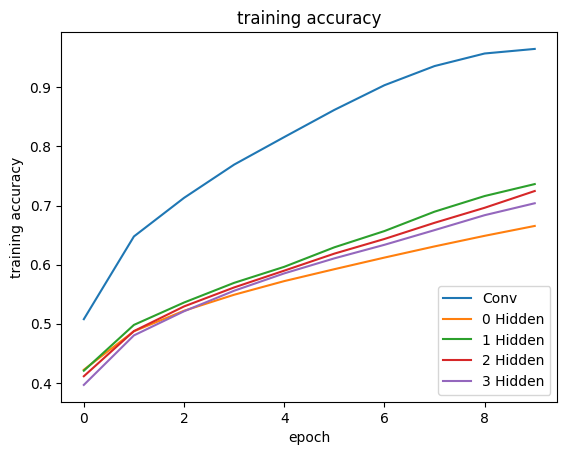

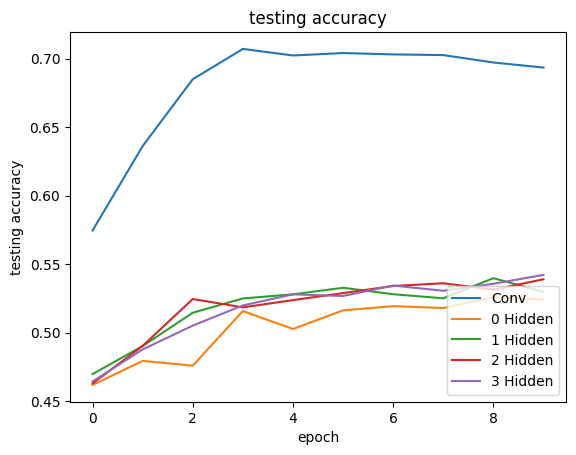

In [14]:
#Plot results for Q1
all_train_accuracies_T = [list(row) for row in zip(*all_train_accuracies)]
plt.plot(all_train_accuracies_T)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','0 Hidden','1 Hidden','2 Hidden','3 Hidden'], loc='lower right')
plt.show()

all_test_accuracies_T = [list(row) for row in zip(*all_test_accuracies)]
plt.plot(all_test_accuracies_T)
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','0 Hidden','1 Hidden','2 Hidden','3 Hidden'], loc='lower right')
plt.show()


### Question 1 explanation:

With the first look we take at the plot we can confirm that CNN performs way better than dense neural networks with any hidden layers from 0 to 3. This is because CNNs perform better for image recognition. The reason for that is that by using filters in CNN, we are able to scan the whole image and look for different features that construct an image of specific shape, whereas with Dense Neural Networks, we don't know what we are looking for and therefore training won't be as efficient, as if there is not relation between any parts of the inputs. But with the help of filters and pooling in CNN, the network can identify features like change in color, edges, etc. to train itself and then look for the same things when exposed to unseen(test) data.

To compare DNN with different number of layers, generelly, the more the number of hidden layers, the better the model performs. However we should be careful that the model can overfit if the number of hidden layers is too large, so there is an optimum # of hidden layers which depends on the model complexity, number of data points avaialable, etc.
In this situation, as expected, the model with 0 hidden layers performs the worst. Between the other 3, looking at the test and train accuracy at epoch 10, we can see that although the model with 3 hidden layers don't perform the best in the training process, it has the best performance when testing with test data as it's test accuracy is the highest among others, which confirms that (generally) the more hidden layers we have, the better. 

In [15]:
# Q2 trainning process
epochs = 10
all_train_accuracies_2 = []
all_test_accuracies_2 = []

for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader,5, model_sig, loss_fn, optimizer_sig)
    all_train_accuracies_2 += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader,5, model_sig, loss_fn)
    all_test_accuracies_2 += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|████▍                                       | 1/10 [00:29<04:27, 29.68s/it]

Epoch 1:	 Train accuracy: 31.4%	 Avg train loss: 1.875431	 Test accuracy: 40.5%	 Avg test loss: 1.629703


 20%|████████▊                                   | 2/10 [00:59<03:56, 29.60s/it]

Epoch 2:	 Train accuracy: 46.7%	 Avg train loss: 1.479701	 Test accuracy: 50.9%	 Avg test loss: 1.352980


 30%|█████████████▏                              | 3/10 [01:29<03:28, 29.78s/it]

Epoch 3:	 Train accuracy: 53.1%	 Avg train loss: 1.309327	 Test accuracy: 54.0%	 Avg test loss: 1.295563


 40%|█████████████████▌                          | 4/10 [01:59<02:59, 29.84s/it]

Epoch 4:	 Train accuracy: 57.2%	 Avg train loss: 1.197534	 Test accuracy: 57.2%	 Avg test loss: 1.172734


 50%|██████████████████████                      | 5/10 [02:29<02:29, 29.94s/it]

Epoch 5:	 Train accuracy: 60.8%	 Avg train loss: 1.103100	 Test accuracy: 58.1%	 Avg test loss: 1.173316


 60%|██████████████████████████▍                 | 6/10 [02:58<01:59, 29.82s/it]

Epoch 6:	 Train accuracy: 63.6%	 Avg train loss: 1.023134	 Test accuracy: 61.0%	 Avg test loss: 1.092372


 70%|██████████████████████████████▊             | 7/10 [03:28<01:29, 29.74s/it]

Epoch 7:	 Train accuracy: 66.8%	 Avg train loss: 0.941556	 Test accuracy: 62.0%	 Avg test loss: 1.054701


 80%|███████████████████████████████████▏        | 8/10 [03:57<00:59, 29.68s/it]

Epoch 8:	 Train accuracy: 69.3%	 Avg train loss: 0.869654	 Test accuracy: 62.6%	 Avg test loss: 1.067104


 90%|███████████████████████████████████████▌    | 9/10 [04:27<00:29, 29.64s/it]

Epoch 9:	 Train accuracy: 72.3%	 Avg train loss: 0.794062	 Test accuracy: 64.7%	 Avg test loss: 1.005098


100%|███████████████████████████████████████████| 10/10 [04:57<00:00, 29.71s/it]

Epoch 10:	 Train accuracy: 74.9%	 Avg train loss: 0.724310	 Test accuracy: 65.4%	 Avg test loss: 0.986330


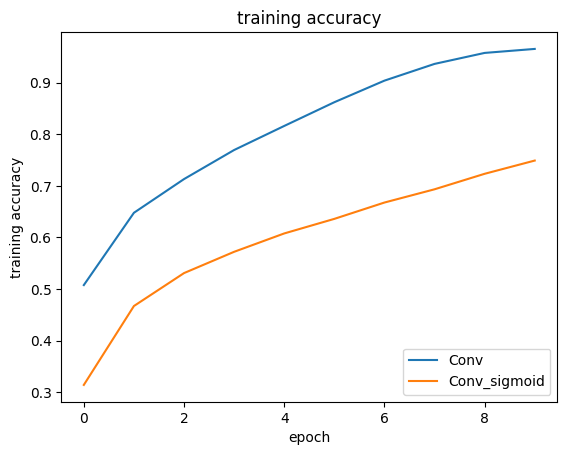

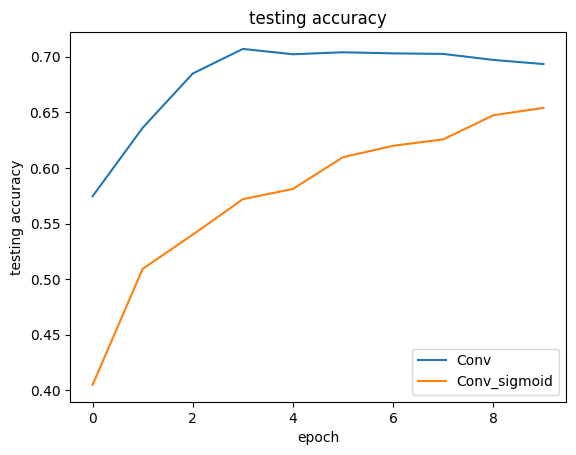

In [16]:
#Plot results for Q2
plt.plot(all_train_accuracies[0],label='Curve 1')
plt.plot(all_train_accuracies_2,label='Curve 2')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','Conv_sigmoid'], loc='lower right')
plt.show()

plt.plot(all_test_accuracies[0],label='Curve 1')
plt.plot(all_test_accuracies_2,label='Curve 2')
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','Conv_sigmoid'], loc='lower right')
plt.show()


### Question 2 explanation:

Normally, using relu is better than using sigmoid because of the problem of vanishing gradients. 
Sigmoid is a function that outputs values between 0 and 1. It's derivative which also appears in gradients has values between 0 and 1. Therefore when we backpropagate, more values between 0 and 1 are being multiplied to each other hence when we want to compute derivates in the primary levels, the gradient becomes close to zero, hence the weights won't be updated and the model won't imporove. 
Relu is a function which it's derivate is either 0 or 1. So the problem of vanishing gradients is resolved using ReLU.
As it is obvious in the graph, the model using ReLU perform way better than the model using sigmoid as it's activation function.

In [17]:
#Trainig process: model With dropout, Q3


epochs = 10
all_train_accuracies_drop = []
#all_train_accuracies = np.zeros((5,10))
#all_train_accuracies_drop = [[0 for j in range(10)] for i in range(5)]
all_test_accuracies_drop = []
#all_test_accuracies_drop = [[0 for j in range(10)] for i in range(5)]
for t in tqdm(range(epochs)):
    avg_tr = 0
    avg_tst = 0
    # train
    train_accuracy, average_train_loss = train(train_dataloader,5, model_drop, loss_fn, optimizer_drop)
    #all_train_accuracies_drop[0][t] = train_accuracy
    all_train_accuracies_drop += [train_accuracy]
    avg_tr = avg_tr + average_train_loss
    test_accuracy, average_test_loss= test(test_dataloader,5, model_drop, loss_fn)
    #all_test_accuracies_drop[0][t] = test_accuracy
    all_test_accuracies_drop += [test_accuracy]
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")
    



 10%|████▍                                       | 1/10 [00:29<04:28, 29.87s/it]

Epoch 1:	 Train accuracy: 45.6%	 Avg train loss: 1.499352	 Test accuracy: 57.6%	 Avg test loss: 1.173801


 20%|████████▊                                   | 2/10 [00:59<03:58, 29.79s/it]

Epoch 2:	 Train accuracy: 56.9%	 Avg train loss: 1.203229	 Test accuracy: 63.4%	 Avg test loss: 1.060066


 30%|█████████████▏                              | 3/10 [01:29<03:28, 29.78s/it]

Epoch 3:	 Train accuracy: 61.8%	 Avg train loss: 1.078921	 Test accuracy: 66.5%	 Avg test loss: 0.950435


 40%|█████████████████▌                          | 4/10 [01:59<02:59, 29.84s/it]

Epoch 4:	 Train accuracy: 64.9%	 Avg train loss: 0.998910	 Test accuracy: 67.5%	 Avg test loss: 0.924347


 50%|██████████████████████                      | 5/10 [02:29<02:29, 29.87s/it]

Epoch 5:	 Train accuracy: 66.7%	 Avg train loss: 0.943974	 Test accuracy: 69.7%	 Avg test loss: 0.869464


 60%|██████████████████████████▍                 | 6/10 [02:59<02:00, 30.06s/it]

Epoch 6:	 Train accuracy: 68.3%	 Avg train loss: 0.899907	 Test accuracy: 70.1%	 Avg test loss: 0.852764


 70%|██████████████████████████████▊             | 7/10 [03:29<01:29, 29.99s/it]

Epoch 7:	 Train accuracy: 69.6%	 Avg train loss: 0.858549	 Test accuracy: 69.8%	 Avg test loss: 0.871492


 80%|███████████████████████████████████▏        | 8/10 [03:59<00:59, 29.90s/it]

Epoch 8:	 Train accuracy: 70.8%	 Avg train loss: 0.830066	 Test accuracy: 72.2%	 Avg test loss: 0.811955


 90%|███████████████████████████████████████▌    | 9/10 [04:29<00:29, 29.87s/it]

Epoch 9:	 Train accuracy: 71.8%	 Avg train loss: 0.798552	 Test accuracy: 72.0%	 Avg test loss: 0.811162


100%|███████████████████████████████████████████| 10/10 [04:58<00:00, 29.90s/it]

Epoch 10:	 Train accuracy: 72.7%	 Avg train loss: 0.774313	 Test accuracy: 72.4%	 Avg test loss: 0.802032


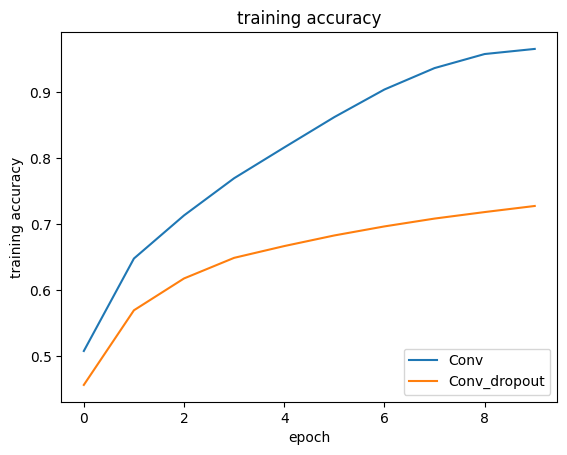

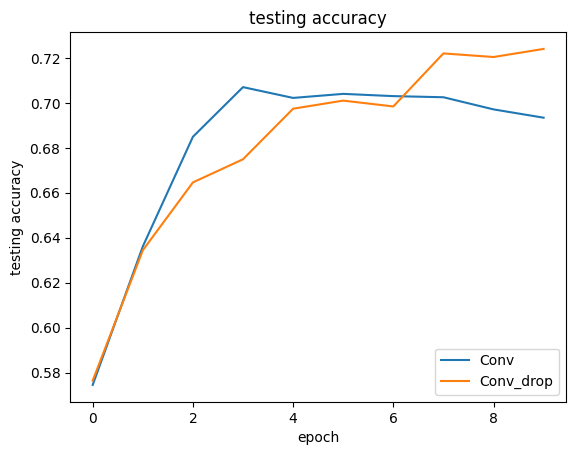

In [18]:
#Plot results for Q3
    
#all_train_accuracies_drop_T =  [list(row) for row in zip(*all_train_accuracies_drop)]   
plt.plot(all_train_accuracies_1,label='Curve 1')
plt.plot(all_train_accuracies_drop,label='Curve 2')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','Conv_dropout'], loc='lower right')
plt.show()

#all_test_accuracies_drop_T = [list(row) for row in zip(*all_test_accuracies_drop)]  
plt.plot(all_test_accuracies_1,label='Curve 1')
plt.plot(all_test_accuracies_drop,label='Curve 2')
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','Conv_drop'], loc='lower right')
plt.show()

## Question 3 explanation

Dropout involves randomly dropping out neurons in the layers with a specific probability. This helps improve the model by preventing the model to overfit by exposing the model to less data, and since in every epoch different neurons are set to zero the capacity of the model to predict unseen data is increased, hence the model will perform better when is exposed to unseen data. This is apparent from the plot as we have less training accuracy (so the model is less(or not) overfit) and is generalized therefore we see a higher test accuracy for the model using dropout.

In [19]:
## Q4 training process with AdaGrad optimizer



epochs = 10


all_train_accuracies_Ada = []

all_test_accuracies_Ada = []
for t in tqdm(range(epochs)):
    avg_tr = 0
    avg_tst = 0
    # train
    train_accuracy, average_train_loss = train(train_dataloader,5, model_Ada, loss_fn, optimizer_Ada)
    
    all_train_accuracies_Ada += [train_accuracy]
    avg_tr = avg_tr + average_train_loss
    
    test_accuracy, average_test_loss = test(test_dataloader,5, model_Ada, loss_fn)
    
    all_test_accuracies_Ada += [test_accuracy]
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")


 10%|████▍                                       | 1/10 [00:29<04:24, 29.37s/it]

Epoch 1:	 Train accuracy: 46.5%	 Avg train loss: 1.487410	 Test accuracy: 54.1%	 Avg test loss: 1.269360


 20%|████████▊                                   | 2/10 [00:58<03:55, 29.42s/it]

Epoch 2:	 Train accuracy: 57.9%	 Avg train loss: 1.176136	 Test accuracy: 59.9%	 Avg test loss: 1.131844


 30%|█████████████▏                              | 3/10 [01:28<03:25, 29.37s/it]

Epoch 3:	 Train accuracy: 62.4%	 Avg train loss: 1.062168	 Test accuracy: 61.7%	 Avg test loss: 1.083874


 40%|█████████████████▌                          | 4/10 [01:57<02:56, 29.34s/it]

Epoch 4:	 Train accuracy: 65.7%	 Avg train loss: 0.976607	 Test accuracy: 61.1%	 Avg test loss: 1.100931


 50%|██████████████████████                      | 5/10 [02:26<02:26, 29.30s/it]

Epoch 5:	 Train accuracy: 68.1%	 Avg train loss: 0.911924	 Test accuracy: 65.5%	 Avg test loss: 0.977615


 60%|██████████████████████████▍                 | 6/10 [02:55<01:57, 29.27s/it]

Epoch 6:	 Train accuracy: 70.0%	 Avg train loss: 0.857694	 Test accuracy: 65.7%	 Avg test loss: 0.984721


 70%|██████████████████████████████▊             | 7/10 [03:25<01:27, 29.27s/it]

Epoch 7:	 Train accuracy: 71.6%	 Avg train loss: 0.810730	 Test accuracy: 67.7%	 Avg test loss: 0.924962


 80%|███████████████████████████████████▏        | 8/10 [03:54<00:58, 29.24s/it]

Epoch 8:	 Train accuracy: 73.3%	 Avg train loss: 0.767524	 Test accuracy: 68.2%	 Avg test loss: 0.921992


 90%|███████████████████████████████████████▌    | 9/10 [04:23<00:29, 29.23s/it]

Epoch 9:	 Train accuracy: 74.8%	 Avg train loss: 0.728336	 Test accuracy: 68.9%	 Avg test loss: 0.895156


100%|███████████████████████████████████████████| 10/10 [04:52<00:00, 29.29s/it]

Epoch 10:	 Train accuracy: 76.0%	 Avg train loss: 0.694100	 Test accuracy: 68.6%	 Avg test loss: 0.906321


In [20]:
## Q4 training process with SGD optimizer
epochs = 10


all_train_accuracies_SGD = []

all_test_accuracies_SGD = []
for t in tqdm(range(epochs)):
    avg_tr = 0
    avg_tst = 0
    # train
    train_accuracy, average_train_loss = train(train_dataloader,5, model_SGD, loss_fn, optimizer_SGD)
    
    all_train_accuracies_SGD += [train_accuracy]
    avg_tr = avg_tr + average_train_loss
    test_accuracy, average_test_loss = test(test_dataloader,5, model_SGD, loss_fn)
    
    all_test_accuracies_SGD += [test_accuracy]
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")


 10%|████▍                                       | 1/10 [00:29<04:21, 29.03s/it]

Epoch 1:	 Train accuracy: 10.9%	 Avg train loss: 2.295727	 Test accuracy: 11.6%	 Avg test loss: 2.287770


 20%|████████▊                                   | 2/10 [00:57<03:51, 28.97s/it]

Epoch 2:	 Train accuracy: 16.1%	 Avg train loss: 2.274891	 Test accuracy: 22.7%	 Avg test loss: 2.255034


 30%|█████████████▏                              | 3/10 [01:26<03:22, 28.92s/it]

Epoch 3:	 Train accuracy: 24.0%	 Avg train loss: 2.217237	 Test accuracy: 25.0%	 Avg test loss: 2.162174


 40%|█████████████████▌                          | 4/10 [01:55<02:53, 28.91s/it]

Epoch 4:	 Train accuracy: 25.6%	 Avg train loss: 2.114835	 Test accuracy: 28.1%	 Avg test loss: 2.061780


 50%|██████████████████████                      | 5/10 [02:24<02:24, 28.93s/it]

Epoch 5:	 Train accuracy: 28.2%	 Avg train loss: 2.036386	 Test accuracy: 29.6%	 Avg test loss: 1.994097


 60%|██████████████████████████▍                 | 6/10 [02:53<01:55, 28.95s/it]

Epoch 6:	 Train accuracy: 30.2%	 Avg train loss: 1.972987	 Test accuracy: 32.0%	 Avg test loss: 1.931876


 70%|██████████████████████████████▊             | 7/10 [03:22<01:26, 28.99s/it]

Epoch 7:	 Train accuracy: 32.4%	 Avg train loss: 1.913100	 Test accuracy: 33.4%	 Avg test loss: 1.875691


 80%|███████████████████████████████████▏        | 8/10 [03:51<00:57, 28.95s/it]

Epoch 8:	 Train accuracy: 34.0%	 Avg train loss: 1.860626	 Test accuracy: 34.8%	 Avg test loss: 1.828658


 90%|███████████████████████████████████████▌    | 9/10 [04:20<00:28, 28.93s/it]

Epoch 9:	 Train accuracy: 35.5%	 Avg train loss: 1.813729	 Test accuracy: 37.1%	 Avg test loss: 1.784018


100%|███████████████████████████████████████████| 10/10 [04:49<00:00, 28.94s/it]

Epoch 10:	 Train accuracy: 37.1%	 Avg train loss: 1.770536	 Test accuracy: 38.0%	 Avg test loss: 1.740564


In [21]:
## Q4 training process with RMSprop optimizer
epochs = 10


all_train_accuracies_RMS = []

all_test_accuracies_RMS = []
for t in tqdm(range(epochs)):
    avg_tr = 0
    avg_tst = 0
    # train
    train_accuracy, average_train_loss = train(train_dataloader,5, model_RMS, loss_fn, optimizer_RMS)
    
    all_train_accuracies_RMS += [train_accuracy]
    avg_tr = avg_tr + average_train_loss
    test_accuracy, average_test_loss = test(test_dataloader,5, model_RMS, loss_fn)
    
    all_test_accuracies_RMS += [test_accuracy]
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")


 10%|████▍                                       | 1/10 [00:29<04:23, 29.32s/it]

Epoch 1:	 Train accuracy: 42.6%	 Avg train loss: 1.613299	 Test accuracy: 47.7%	 Avg test loss: 1.470338


 20%|████████▊                                   | 2/10 [00:58<03:54, 29.29s/it]

Epoch 2:	 Train accuracy: 50.5%	 Avg train loss: 1.396626	 Test accuracy: 49.1%	 Avg test loss: 1.403794


 30%|█████████████▏                              | 3/10 [01:27<03:24, 29.27s/it]

Epoch 3:	 Train accuracy: 54.3%	 Avg train loss: 1.298459	 Test accuracy: 54.3%	 Avg test loss: 1.277258


 40%|█████████████████▌                          | 4/10 [01:57<02:55, 29.29s/it]

Epoch 4:	 Train accuracy: 56.8%	 Avg train loss: 1.220862	 Test accuracy: 55.8%	 Avg test loss: 1.233208


 50%|██████████████████████                      | 5/10 [02:26<02:26, 29.30s/it]

Epoch 5:	 Train accuracy: 59.4%	 Avg train loss: 1.153973	 Test accuracy: 56.5%	 Avg test loss: 1.226490


 60%|██████████████████████████▍                 | 6/10 [02:55<01:57, 29.28s/it]

Epoch 6:	 Train accuracy: 61.6%	 Avg train loss: 1.096113	 Test accuracy: 60.5%	 Avg test loss: 1.114898


 70%|██████████████████████████████▊             | 7/10 [03:25<01:27, 29.29s/it]

Epoch 7:	 Train accuracy: 63.4%	 Avg train loss: 1.046796	 Test accuracy: 60.4%	 Avg test loss: 1.116852


 80%|███████████████████████████████████▏        | 8/10 [03:54<00:58, 29.30s/it]

Epoch 8:	 Train accuracy: 65.1%	 Avg train loss: 1.001311	 Test accuracy: 61.3%	 Avg test loss: 1.103480


 90%|███████████████████████████████████████▌    | 9/10 [04:23<00:29, 29.30s/it]

Epoch 9:	 Train accuracy: 66.5%	 Avg train loss: 0.962305	 Test accuracy: 63.4%	 Avg test loss: 1.044276


100%|███████████████████████████████████████████| 10/10 [04:52<00:00, 29.29s/it]

Epoch 10:	 Train accuracy: 67.8%	 Avg train loss: 0.926591	 Test accuracy: 63.4%	 Avg test loss: 1.051131


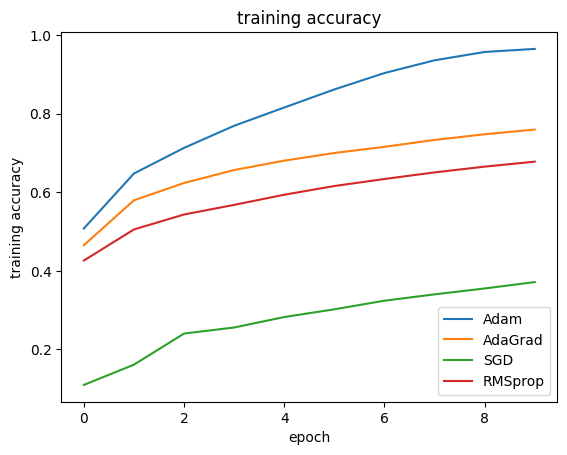

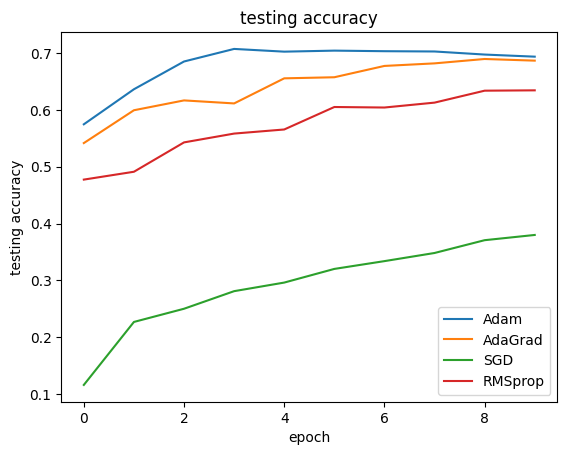

In [22]:
#Plot Q4
    
#all_train_accuracies_drop_T =  [list(row) for row in zip(*all_train_accuracies_drop)]   
plt.plot(all_train_accuracies_1,label='Curve 1')
plt.plot(all_train_accuracies_Ada,label='Curve 2')
plt.plot(all_train_accuracies_SGD,label='Curve 3')
plt.plot(all_train_accuracies_RMS,label='Curve 4')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Adam','AdaGrad','SGD','RMSprop'], loc='lower right')
plt.show()

#all_test_accuracies_drop_T = [list(row) for row in zip(*all_test_accuracies_drop)]  
plt.plot(all_test_accuracies_1,label='Curve 1')
plt.plot(all_test_accuracies_Ada,label='Curve 2')
plt.plot(all_test_accuracies_SGD,label='Curve 3')
plt.plot(all_test_accuracies_RMS,label='Curve 4')
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Adam','AdaGrad','SGD','RMSprop'], loc='lower right')
plt.show()

## Question 4 explanation:
As expected, Adam optimizer performs better than Adagrad, Adagrad performs better than RMSprop, and RMSprop is better than SGD. 
SGD has the least performance since it takes huge steps in the direction of largest gradient descent(which is not always ideal), and when it is faced in the direction of the optimum, it takes really small steps so it lacks momentum as well.
For Adagrad, the idea is to adjust the learning rate of each dimension separately, but the problem is that the learning rate decays quickly. In RMSprop, the idea is to divide by root mean square (RMS) (instead of root of the sum) of partial derivatives, but in this case the gradient lacks momentum. These two optimizers can perform better than one another in different cases. In this case their test accuracy at epoch=10 is very close to each other.
On the other hand, Adam optimizer replaces gradient by its moving average to induce momentum, so the issue with the other optimizers is resolved, and that is why we can see it has the best test accuracy among other models.

In [23]:
#Q5 training process

epochs = 10

all_train_accuracies_3b3 = []

all_test_accuracies_3b3 = []
for t in tqdm(range(epochs)):
    avg_tr = 0
    avg_tst = 0
    # train
    train_accuracy, average_train_loss = train(train_dataloader,5, model_3b3, loss_fn, optimizer_3b3)
    
    all_train_accuracies_3b3 += [train_accuracy]
    avg_tr = avg_tr + average_train_loss
    test_accuracy, average_test_loss = test(test_dataloader,5, model_3b3, loss_fn)
    
    all_test_accuracies_3b3 += [test_accuracy]
    avg_tst = avg_tst + average_test_loss
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")


 10%|████▍                                       | 1/10 [00:30<04:35, 30.61s/it]

Epoch 1:	 Train accuracy: 47.1%	 Avg train loss: 1.452276	 Test accuracy: 56.7%	 Avg test loss: 1.200982


 20%|████████▊                                   | 2/10 [01:00<04:03, 30.40s/it]

Epoch 2:	 Train accuracy: 63.6%	 Avg train loss: 1.027154	 Test accuracy: 64.6%	 Avg test loss: 0.991458


 30%|█████████████▏                              | 3/10 [01:31<03:32, 30.33s/it]

Epoch 3:	 Train accuracy: 70.5%	 Avg train loss: 0.829741	 Test accuracy: 69.9%	 Avg test loss: 0.853620


 40%|█████████████████▌                          | 4/10 [02:00<03:00, 30.13s/it]

Epoch 4:	 Train accuracy: 76.2%	 Avg train loss: 0.676973	 Test accuracy: 71.6%	 Avg test loss: 0.827282


 50%|██████████████████████                      | 5/10 [02:31<02:30, 30.14s/it]

Epoch 5:	 Train accuracy: 80.7%	 Avg train loss: 0.544136	 Test accuracy: 72.9%	 Avg test loss: 0.809949


 60%|██████████████████████████▍                 | 6/10 [03:01<02:00, 30.13s/it]

Epoch 6:	 Train accuracy: 85.5%	 Avg train loss: 0.415834	 Test accuracy: 72.5%	 Avg test loss: 0.885515


 70%|██████████████████████████████▊             | 7/10 [03:31<01:30, 30.08s/it]

Epoch 7:	 Train accuracy: 89.5%	 Avg train loss: 0.298722	 Test accuracy: 72.8%	 Avg test loss: 0.992171


 80%|███████████████████████████████████▏        | 8/10 [04:01<01:00, 30.06s/it]

Epoch 8:	 Train accuracy: 92.8%	 Avg train loss: 0.206014	 Test accuracy: 71.0%	 Avg test loss: 1.182263


 90%|███████████████████████████████████████▌    | 9/10 [04:31<00:30, 30.05s/it]

Epoch 9:	 Train accuracy: 95.1%	 Avg train loss: 0.141858	 Test accuracy: 71.4%	 Avg test loss: 1.337394


100%|███████████████████████████████████████████| 10/10 [05:01<00:00, 30.12s/it]

Epoch 10:	 Train accuracy: 96.0%	 Avg train loss: 0.114511	 Test accuracy: 71.1%	 Avg test loss: 1.536172


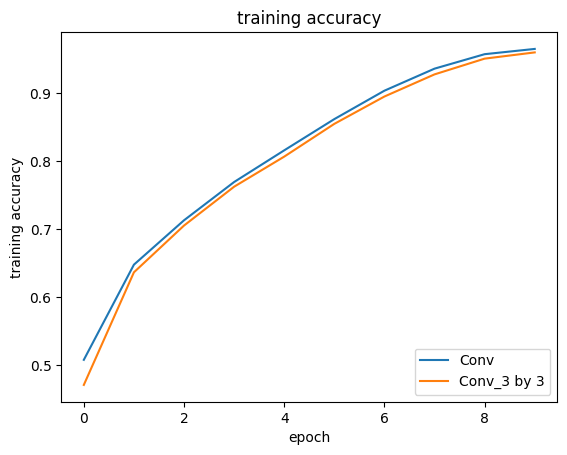

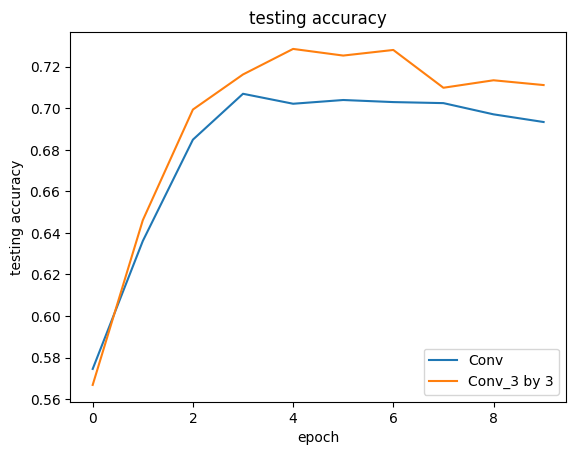

In [24]:
#Plot Q5
    
#all_train_accuracies_drop_T =  [list(row) for row in zip(*all_train_accuracies_drop)]   
plt.plot(all_train_accuracies_1,label='Curve 1')
plt.plot(all_train_accuracies_3b3,label='Curve 2')
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','Conv_3 by 3'], loc='lower right')
plt.show()

#all_test_accuracies_drop_T = [list(row) for row in zip(*all_test_accuracies_drop)]  
plt.plot(all_test_accuracies_1,label='Curve 1')
plt.plot(all_test_accuracies_3b3,label='Curve 2')
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Conv','Conv_3 by 3'], loc='lower right')
plt.show()

## Question 5 explanation:

If we replace the 5 by 5 filter with two 3 by 3 filters, we are improving the CNN by different aspects.
First of all by using 2 filters instead of one , we are making the network deeper. Deeper networks are generally preferred as they have a higher expressivity (Stack of smaller filters are preferred to single large filter). Plus, with smaller filters, there are fewer parameters to be optimized and determined, so the accuracy of prediction icreases. This is evident from the plot, as the CNN with two 3by3 filters has a higher testing accuracy at each epoch than the CNN with single 5by5 filter.

## Question 6


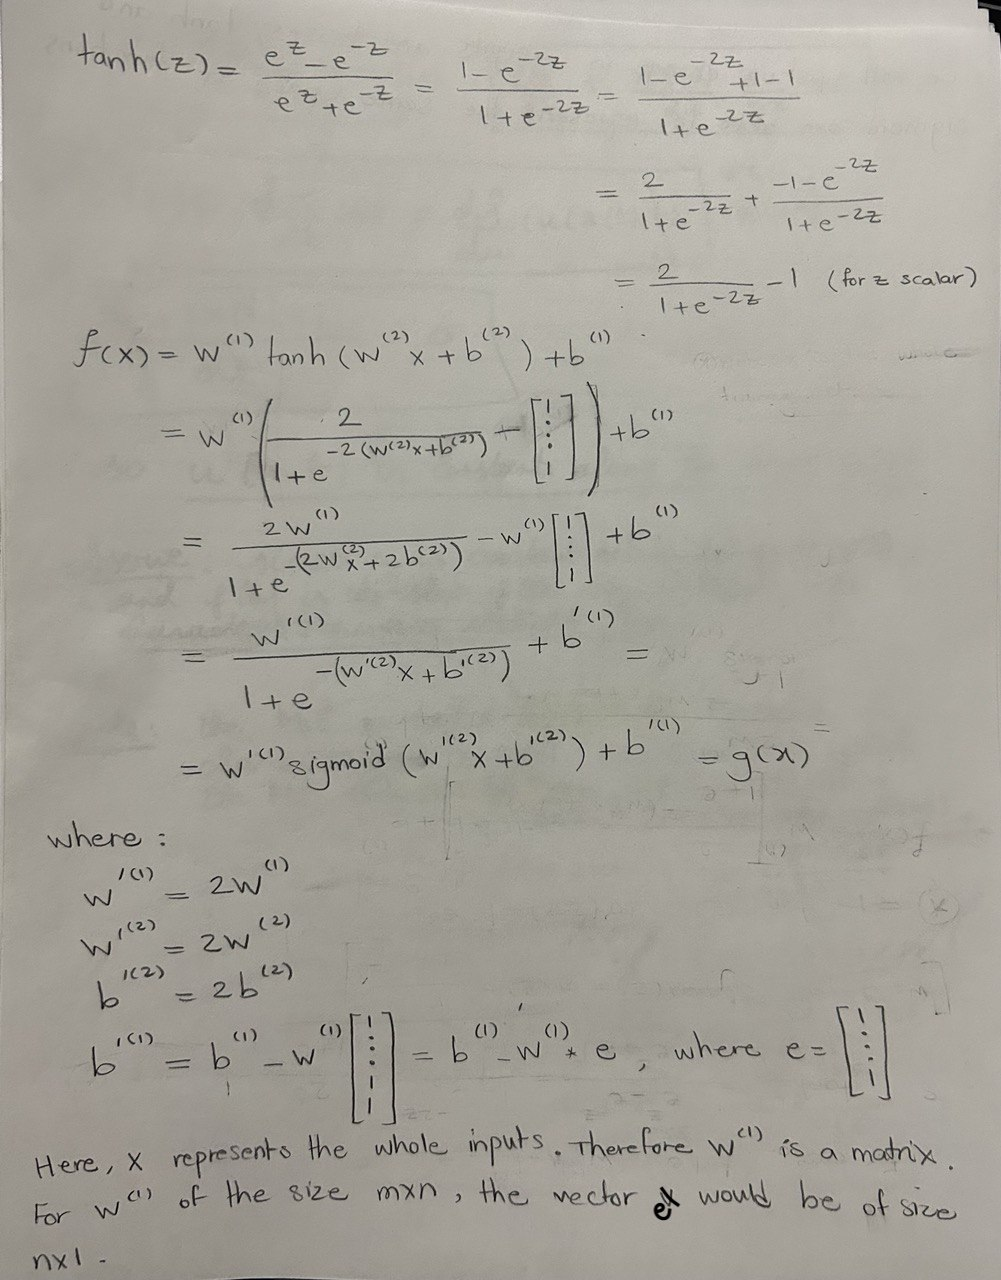

So with just a change in weights and biases, tanh and sigmoid are able to represent the same space of functions.
